# Daniel Bairamian 260669560 
## ECSE 415 Computer Vision
### Assignment 3 Part Two

# Motion Algorithm

# Multi-resolution Lucas-Kanade optic flow detection

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from skimage import color

In [2]:
# Helper function to show images
def show_images(images, cols , titles):
    
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(image, cmap="gray")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [3]:
EPSILON = 1e-8

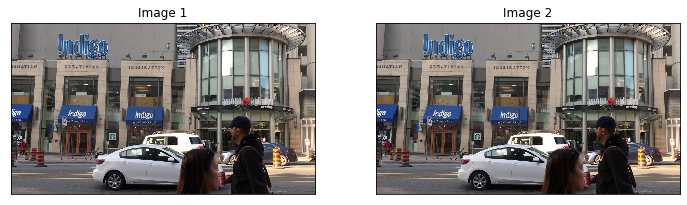

In [4]:
# load image
img1         = cv2.imread("frame1.png")
img2         = cv2.imread("frame2.png")


img1RGB      = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2RGB)
img2RGB      = cv2.cvtColor(img1.copy(), cv2.COLOR_BGR2RGB)

img1G        = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2G        = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


original_images = [img1RGB, img2RGB]
original_titles = ["Image 1", "Image 2"]

show_images(original_images, len(original_images)/2, original_titles)

In [5]:
"""
Function that searches for the optimal parameters

Optimal parameter is determined by the error returned by calcOpticalFlowPyrLK

To compute this error, we take the points that are successful (st = 1) and then compute the norm of the remaining points

After doing some testing, I realized that the norm of these points tends to be very small,
especially if almost no points were detected. This is why, as a heuristic,
I divide the computed norm by the length of the vector.
This heuristic intuitively incentivises the algorithm to find the parameters with a lot of points
but with a low error. 

This would avoid returning parameters that have little to no effect, and thus a naturally low error.

"""


def LKParamSearch(img1, img2, quality_vals, distance_vals, block_vals, winsize_vals):
    
    best_params  = []
    lowest_error = 1e32 # <-- random huge number
    
    iter_count   = 1
    total_iters  = len(quality_vals)*len(distance_vals)*len(block_vals)*len(winsize_vals)
    
    for q in quality_vals:
        for d in distance_vals:
            for b in block_vals:
                for w in winsize_vals:
                    feature_params = dict( maxCorners = 500,
                           qualityLevel = q,
                           minDistance = d,
                           blockSize = b )
                    
                    #print("Iter: ", iter_count, "/", total_iters
                    
                    lk_params = dict( winSize = (w,w), maxLevel = 1)

                    p0 = cv2.goodFeaturesToTrack(img1, **feature_params)
                    p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, p0, None, **lk_params)
                    
                    err = err[st==1]                    
                    current_err = (np.linalg.norm(err)/( len(err) + EPSILON ))
                    #current_err = (np.linalg.norm(err))
                    
                    if (lowest_error > current_err):
                        lowest_error = current_err
                        best_params = [p0, p1, st, err, q, d, b, w]
                    iter_count += 1
                    
    return best_params

In [6]:
qualities = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8]
distances = [1, 10, 50, 100]
blocks    = [3, 5, 10, 15, 30]
windows   = [15, 30, 50]


params = LKParamSearch(img1G, img2G, qualities, distances, blocks, windows)

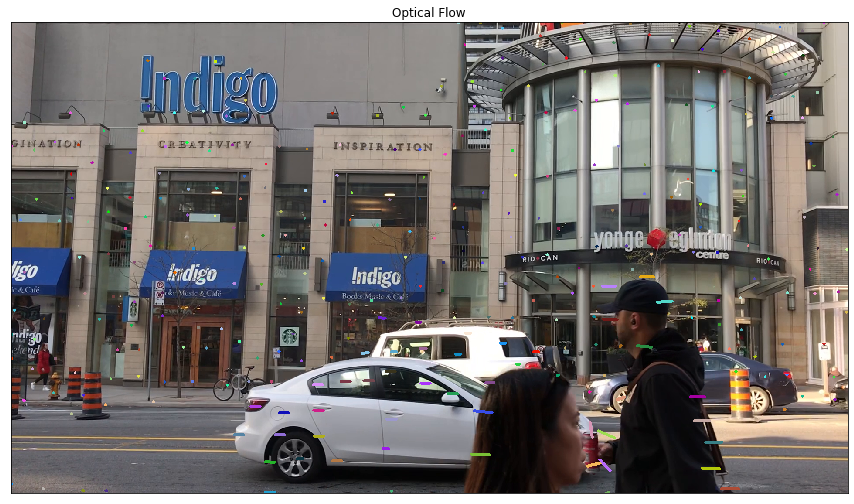

In [7]:
# select good points
good_new = params[1][params[2]==1]
good_old = params[0][params[2]==1]

# create some random colors
color = np.random.randint(0, 255, (good_new.shape[0], 3))

# create a mask image for drawing purposes
mask = img1RGB.copy()

# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 5)

# display images
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
quality_lev = params[4]
min_distance  = params[5]
block         = params[6]
windowsize    = params[7]


print("Best Parameters:")
print("quality_level: ", params[4])
print("min_distance: " , params[5])
print("blocksize: "    , params[6])
print("windowsize: "   , params[7])

Best Parameters:
quality_level:  0.01
min_distance:  50
blocksize:  30
windowsize:  50


In [9]:
pyramid_levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
feature_params = dict( maxCorners = 500,
                           qualityLevel = quality_lev,
                           minDistance = min_distance,
                           blockSize = block )

p0 = cv2.goodFeaturesToTrack(img1G, **feature_params)

error_list = []
images = []
titles = []
for level in pyramid_levels:
    lk_params = dict( winSize = (windowsize,windowsize), maxLevel = level)
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1G, img2G, p0, None, **lk_params)
    err = err[st==1]
    #error_current = (np.linalg.norm(err)/( len(err) + EPSILON ))
    error_current = (np.linalg.norm(err))
    error_list.append(error_current)
    
    
    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # create some random colors
    color = np.random.randint(0, 255, (good_new.shape[0], 3))

    # create a mask image for drawing purposes
    mask = img1RGB.copy()

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 5)
        
    images.append(mask)
    titles.append("Pyramid Level = " + str(level) + " Error =" + str(error_current))

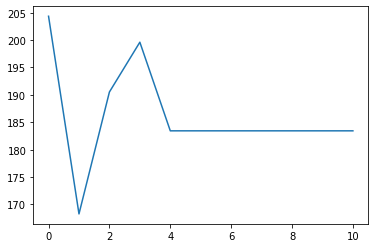

In [10]:
# X ticks: pyramid_levels
# Y ticks: error_list


plt.plot(pyramid_levels, error_list)

### From the plot above, we can see that the error is at its highest for level = 0, lowest for level = 1, then shoots back up at level = 3, but then from 4 to 10 stabilizes to a value in between. 

### The image we have has more than 3 distinct depth planes where action is happening. The first depth plane is the one closest to the camera, where we can see two people walking.  The second depth plane is the one with the two cars driving. Finally, the last depth plane contains the buildings.

### From the three depth planes, the first two mentionned contain almost all the motion in the picture. The third one contains motions from the specular reflections on the building windows.

### It then makes sense that the lowest error value is achieved for level =1, since according to the documentation of the calcOpticalFlowPyrLK() function, for level = 1, the algorithm uses 2 levels in the pyramid. 

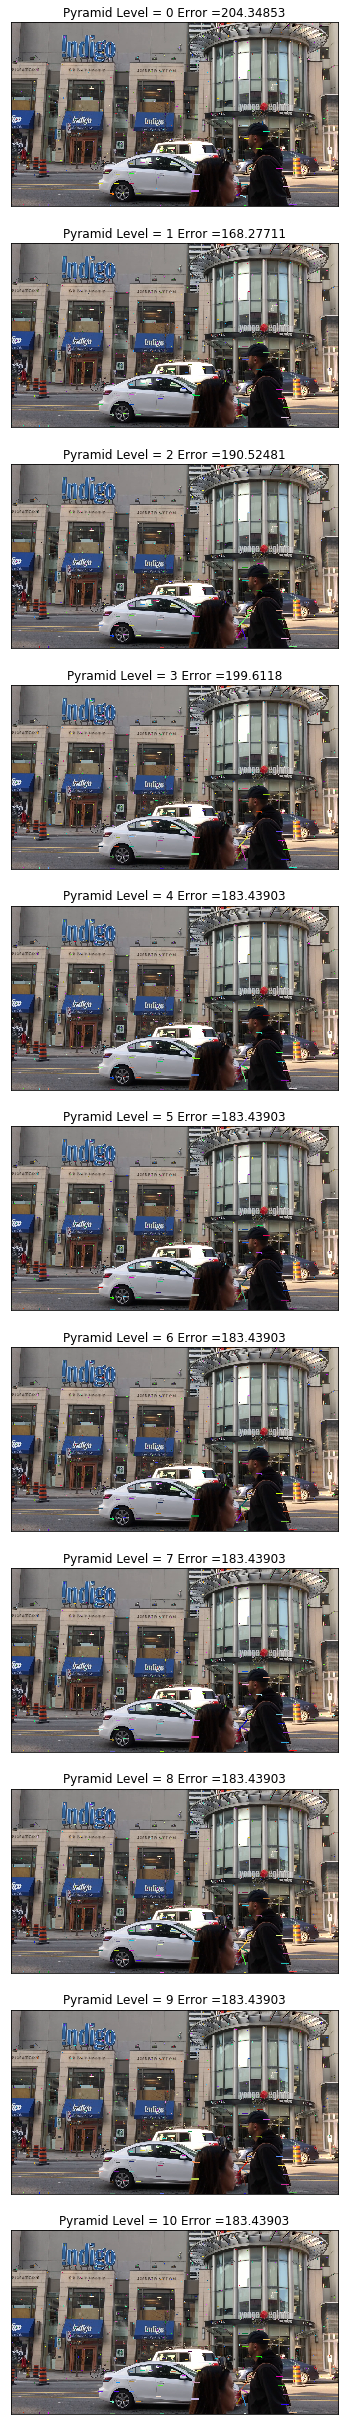

In [11]:
show_images(images, len(images), titles)

### The higher the maximum level value, the lesser the quality of the foreground motion vector is seems. As the algorithm is given more levels to assess, it seems to take a hit on the quality of the foreground, which for this picture is the most important part as far as motion is concerned, as it contains most of not all the movement of the scene. 